In [3]:
import pandas as pd
import json
from sqlalchemy import create_engine

In [4]:
with open('/kaggle/input/yelp-dataset/yelp_academic_dataset_business.json','r') as f:
    business_data= [json.loads(line) for line in f]
    business_df = pd.DataFrame(business_data)
with open('/kaggle/input/yelp-dataset/yelp_academic_dataset_checkin.json', 'r') as f:
    checkin_data = [json.loads(line) for line in f]
checkin_df = pd.DataFrame(checkin_data)

with open('/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json', 'r') as f:
    review_data = [json.loads(line) for line in f]
review_df = pd.DataFrame(review_data)

with open('/kaggle/input/yelp-dataset/yelp_academic_dataset_tip.json', 'r') as f:
    tip_data = [json.loads(line) for line in f]
tip_df = pd.DataFrame(tip_data)

with open('/kaggle/input/yelp-dataset/yelp_academic_dataset_user.json', 'r') as f:
    user_data = [json.loads(line) for line in f]
user_df = pd.DataFrame(user_data)

In [5]:
print(business_df.shape)
print(checkin_df.shape)
print(review_df.shape)
print(tip_df.shape)
print(user_df.shape)

(150346, 14)
(131930, 2)
(6990280, 9)
(908915, 5)
(1987897, 22)


In [6]:
business_df.drop(['attributes', 'hours'],axis = 1, inplace = True)

In [7]:
engine = create_engine('sqlite:////kaggle/working/yelp.db')
def load_dataframe(df, table_name, engine):
    df.to_sql(table_name, con=engine, if_exists='replace', index=False)

load_dataframe(business_df,'business',engine)
load_dataframe(review_df, 'review', engine)
load_dataframe(user_df, 'user', engine)
load_dataframe(tip_df, 'tip', engine)
load_dataframe(checkin_df, 'checkin', engine)

In [10]:
# Optional: confirm tables were created
import sqlite3
conn = sqlite3.connect('/kaggle/working/yelp.db')
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
print(tables)


       name
0  business
1    review
2      user
3       tip
4   checkin


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
import sqlite3
import folium
from geopy.geocoders import Nominatim
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [12]:
tables

,name
0,business
1,review
2,user
3,tip
4,checkin


In [17]:
for table in tables['name']:
    print(f"\nPreview of table: {table}")
    display(pd.read_sql_query(f"SELECT * FROM {table} LIMIT 5", conn))



Preview of table: business


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,"Doctors, Traditional Chinese Medicine, Naturop..."
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,"Shipping Centers, Local Services, Notaries, Ma..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"Department Stores, Shopping, Fashion, Home & G..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"Brewpubs, Breweries, Food"



Preview of table: review


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15



Preview of table: user


,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,"NSCy54eWehBJyZdG2iE84w, pe42u7DcCH2QmI81NX-8qA...",267,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...","ueRPE0CX75ePGMqOFVj6IQ, 52oH4DrRvzzl8wh5UXyU0A...",3138,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013","LuO3Bn4f3rlhyHIaNfTlnA, j9B4XdHUhDfTKVecyWQgyA...",52,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011","enx1vVPnfdNUdPho6PH_wg, 4wOcvMLtU6a9Lslggq74Vg...",28,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,"PBK4q9KEEBHhFvSXCUirIw, 3FWPpM7KU1gXeOM_ZbYMbA...",1,...,1,0,0,0,1,1,0,0,0,0



Preview of table: tip


,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0



Preview of table: checkin


,business_id,date
0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."
2,--30_8IhuyMHbSOcNWd6DQ,"2013-06-14 23:29:17, 2014-08-13 23:20:22"
3,--7PUidqRWpRSpXebiyxTg,"2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012..."
4,--7jw19RH9JKXgFohspgQw,"2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014..."


In [23]:
business_id = pd.read_sql_query("SELECT business_id, review_count FROM business WHERE LOWER(categories) LIKE '%restaurants%' AND is_open = 1 ",conn)

In [21]:
pd.read_sql_query(f"""
SELECT 
    AVG(review_count) AS average_review_count,
    MIN(review_count) AS min_review_count,
    MAX(review_count) AS max_review_count,
    (
        SELECT review_count 
        FROM business 
        ORDER BY review_count 
        LIMIT 1 OFFSET (SELECT COUNT(*) FROM business) / 2
    ) AS median_review_count,

    AVG(stars) AS average_star_rating,
    MIN(stars) AS min_star_rating,
    MAX(stars) AS max_star_rating,
    (
        SELECT stars 
        FROM business 
        ORDER BY stars 
        LIMIT 1 OFFSET (SELECT COUNT(*) FROM business) / 2
    ) AS median_star_rating

FROM business
WHERE business_id IN {tuple(business_id['business_id'])}
""", conn).transpose()

,0
average_review_count,104.142767
min_review_count,5.000000
max_review_count,7568.000000
median_review_count,15.000000
average_star_rating,3.523895
min_star_rating,1.000000
max_star_rating,5.000000
median_star_rating,3.500000


In [29]:
def remove_outliers(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df


In [30]:
business_id = remove_outliers(business_id, 'review_count')

In [31]:
business_id.shape

(31520, 2)

In [32]:
pd.read_sql_query(f"""
SELECT 
    AVG(review_count) AS average_review_count,
    MIN(review_count) AS min_review_count,
    MAX(review_count) AS max_review_count,
    (
        SELECT review_count 
        FROM business 
        ORDER BY review_count 
        LIMIT 1 OFFSET (SELECT COUNT(*) FROM business) / 2
    ) AS median_review_count,

    AVG(stars) AS average_star_rating,
    MIN(stars) AS min_star_rating,
    MAX(stars) AS max_star_rating,
    (
        SELECT stars 
        FROM business 
        ORDER BY stars 
        LIMIT 1 OFFSET (SELECT COUNT(*) FROM business) / 2
    ) AS median_star_rating

FROM business
WHERE business_id IN {tuple(business_id['business_id'])}
""", conn).transpose()

,0
average_review_count,55.999397
min_review_count,5.000000
max_review_count,248.000000
median_review_count,15.000000
average_star_rating,3.477173
min_star_rating,1.000000
max_star_rating,5.000000
median_star_rating,3.500000


In [33]:
#which restaurant has the highest number of reviews
pd.read_sql_query(f"SELECT name, SUM(review_count) AS review_count, AVG(stars) as avg_rating From business WHERE business_id in {tuple(business_id['business_id'])} GROUP BY name Order BY review_count DESC LIMIT 10",conn)

,name,review_count,avg_rating
0,McDonald's,16490,1.868702
1,Chipotle Mexican Grill,9071,2.381757
2,Taco Bell,8017,2.141813
3,Chick-fil-A,7687,3.377419
4,First Watch,6761,3.875000
5,Panera Bread,6613,2.661905
6,Buffalo Wild Wings,6483,2.344828
7,Domino's Pizza,6091,2.290210
8,Wendy's,5930,2.030159
9,Chili's,5744,2.514706


In [35]:
pd.read_sql_query(f"SELECT name, SUM(review_count) AS review_count, AVG(stars) as avg_rating From business WHERE business_id in {tuple(business_id['business_id'])} GROUP BY name Order BY avg_rating DESC LIMIT 10",conn)

,name,review_count,avg_rating
0,ā café,48,5.0
1,two birds cafe,77,5.0
2,the brewers cabinet production,13,5.0
3,taqueria la cañada,17,5.0
4,la bamba,44,5.0
5,la 5th av tacos,24,5.0
6,el sabor mexican and chinese food,21,5.0
7,eat.drink.Om...YOGA CAFE,7,5.0
8,d4 Tabletop Gaming Cafe,8,5.0
9,cabbage vegetarian cafe,12,5.0


In [38]:
#do restaurant have higher engagement tends to have higher ratings.?
pd.read_sql_query("""
SELECT 
    business_id, 
    SUM(LENGTH(date) - LENGTH(REPLACE(date, ',', ''))) + 1 AS checkin_count 
FROM checkin 
GROUP BY business_id
""", conn)


,business_id,checkin_count
0,---kPU91CF4Lq2-WlRu9Lw,11
1,--0iUa4sNDFiZFrAdIWhZQ,10
2,--30_8IhuyMHbSOcNWd6DQ,2
3,--7PUidqRWpRSpXebiyxTg,10
4,--7jw19RH9JKXgFohspgQw,26
...,...,...
131925,zznJox6-nmXlGYNWgTDwQQ,67
131926,zznZqH9CiAznbkV6fXyHWA,1
131927,zzu6_r3DxBJuXcjnOYVdTw,23
131928,zzw66H6hVjXQEt0Js3Mo4A,2


In [40]:
pd.read_sql_query("""
SELECT 
    business_id, 
    COUNT(*) AS tip_count 
FROM tip 
GROUP BY business_id
""", conn)


,business_id,tip_count
0,---kPU91CF4Lq2-WlRu9Lw,4
1,--0iUa4sNDFiZFrAdIWhZQ,6
2,--30_8IhuyMHbSOcNWd6DQ,1
3,--7PUidqRWpRSpXebiyxTg,3
4,--8IbOsAAxjKRoYsBFL-PA,4
...,...,...
106188,zzjCxn89a7RQo8keIOO_Ag,1
106189,zzjFdJwXuxBOGe9JeY_EMw,2
106190,zznJox6-nmXlGYNWgTDwQQ,6
106191,zzu6_r3DxBJuXcjnOYVdTw,2


In [42]:
review_count_df= pd.read_sql_query(f"""
SELECT 
    total.avg_rating AS rating,
    AVG(total.review_count) AS avg_review_count,
    AVG(total.checkin_count) AS avg_checkin_count,
    AVG(total.tip_count) AS avg_tip_count
FROM (
    SELECT 
        b.business_id,
        SUM(b.review_count) AS review_count,
        AVG(b.stars) AS avg_rating,
        SUM(LENGTH(cc.date) - LENGTH(REPLACE(cc.date, ',', '')) + 1) AS checkin_count,
        SUM(tip.tip_count) AS tip_count
    FROM business b
    LEFT JOIN checkin cc ON b.business_id = cc.business_id
    LEFT JOIN (
        SELECT business_id, COUNT(business_id) AS tip_count 
        FROM tip 
        GROUP BY business_id
    ) AS tip ON b.business_id = tip.business_id
    WHERE b.business_id IN {tuple(business_id['business_id'])}
    GROUP BY b.business_id
) AS total
GROUP BY total.avg_rating
""", conn)


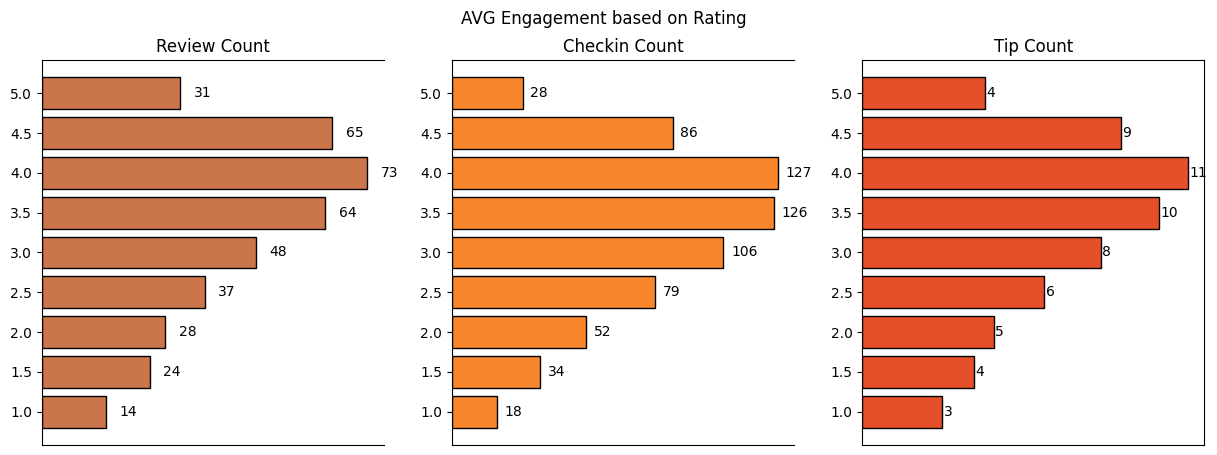

In [43]:
plt.figure(figsize=(15, 5))
plt.suptitle('AVG Engagement based on Rating\n\n')
plt.yticks([])

# Subplot 1: Review Count
plt.subplot(1, 3, 1)
plt.title('Review Count')
plt.barh(
    review_count_df['rating'].astype(str),
    review_count_df['avg_review_count'],
    edgecolor='k',
    color='#CB754B'
)
plt.gca().spines['right'].set_visible(False)
for i, value in enumerate(review_count_df['avg_review_count']):
    plt.text(value + 3, i, str(round(value)), color='black', va='center')

plt.xticks([])

# Subplot 2: Checkin Count
plt.subplot(1, 3, 2)
plt.title('Checkin Count')
plt.barh(
    review_count_df['rating'].astype(str),
    review_count_df['avg_checkin_count'],
    edgecolor='k',
    color='#F8862C'
)
plt.gca().spines['right'].set_visible(False)
for i, value in enumerate(review_count_df['avg_checkin_count']):
    plt.text(value + 3, i, str(round(value)), color='black', va='center')

plt.xticks([])

# Subplot 3: Tip Count
plt.subplot(1, 3, 3)
plt.title('Tip Count')
plt.barh(
    review_count_df['rating'].astype(str),
    review_count_df['avg_tip_count'],
    edgecolor='k',
    color='#E54F29'
)
for i, value in enumerate(review_count_df['avg_tip_count']):
    plt.text(value + 0.05, i, str(round(value)), color='black', va='center')

plt.xticks([])
plt.show()


In [56]:
#is there a corelation between the review count checkin count and the tip count.?
engagement_df= pd.read_sql_query(f"""
    SELECT 
        b.business_id,
        SUM(b.review_count) AS review_count,
        AVG(b.stars) AS avg_rating,
        SUM(LENGTH(cc.date) - LENGTH(REPLACE(cc.date, ',', '')) + 1) AS checkin_count,
        SUM(tip.tip_count) AS tip_count,
        (CASE WHEN b.stars >= 3.5 THEN 'High rated' ELSE 'low rated' END) AS category
    FROM business b
    LEFT JOIN checkin cc ON b.business_id = cc.business_id
    LEFT JOIN (
        SELECT business_id, COUNT(business_id) AS tip_count 
        FROM tip 
        GROUP BY business_id
    ) AS tip ON b.business_id = tip.business_id
    WHERE b.business_id IN {tuple(business_id['business_id'])}
    GROUP BY b.business_id
""", conn).dropna()


In [51]:
engagement_df[['review_count','checkin_count','tip_count'] ].corr()

,review_count,checkin_count,tip_count
review_count,1.000000,0.626837,0.766273
checkin_count,0.626837,1.000000,0.772061
tip_count,0.766273,0.772061,1.000000


<Axes: >

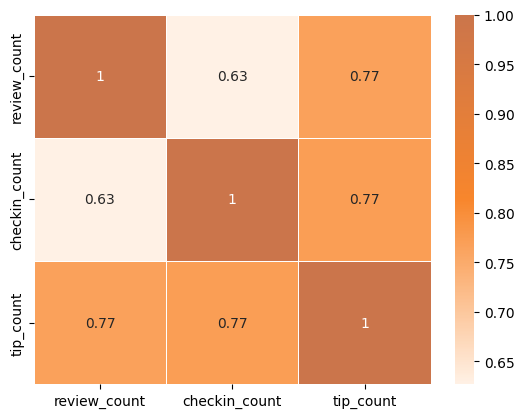

In [52]:
colors = ['#FFF1E5', '#F8862C', '#CB754B']
custom_cmap = LinearSegmentedColormap.from_list("mycmap", colors)

sns.heatmap(
    engagement_df[['review_count', 'checkin_count', 'tip_count']].corr(),
    cmap=custom_cmap,
    annot=True,
    linewidths=0.5,
    linecolor='white'
)


In [57]:
engagement_df.groupby("category")[['review_count','checkin_count','tip_count']].mean()

,review_count,checkin_count,tip_count
category,,,
High rated,72.319991,122.106865,10.166411
low rated,42.132915,88.905759,6.543136


In [58]:
#function to calculate the success score based on the avg ratings and total count.
def calculate_success_metric(df):
    success_score = []
    for index, row in df.iterrows():
        score = row['avg_rating'] * np.log(row['review_count'] + 1)
        success_score.append(score)
    return success_score

In [66]:
#how do the success metrix(review_count or avg_count) of the restaurant vary across different stated and cities.?

city_df = pd.read_sql_query(f""" SELECT city, state, latitude, longitude, AVG(stars) AS avg_rating, SUM(review_count) AS review_count,
COUNT(*) AS restaurant_count
FROM business
WHERE business_id IN {tuple(business_id['business_id'])} 
GROUP BY state, city 
ORDER BY review_count DESC 
LIMIT 10""",conn)
city_df['success_score'] = calculate_success_metric(city_df)

In [67]:
city_df

,city,state,latitude,longitude,avg_rating,review_count,restaurant_count,success_score
0,Philadelphia,PA,39.955505,-75.155564,3.532011,175470,2999,42.649838
1,Tampa,FL,27.890814,-82.502346,3.571179,104368,1714,41.267425
2,Indianapolis,IN,39.637133,-86.127217,3.412111,92639,1701,39.022521
3,Tucson,AZ,32.338572,-111.010760,3.385512,91562,1415,38.678743
4,Nashville,TN,36.208102,-86.768170,3.493590,87070,1404,39.737764
5,New Orleans,LA,29.963974,-90.042604,3.692878,69233,1011,41.158043
6,Saint Louis,MO,38.583223,-90.407187,3.412963,51482,810,37.027259
7,Reno,NV,39.476518,-119.784037,3.478705,48340,587,37.521438
8,Edmonton,AB,53.436403,-113.604288,3.509379,45916,1546,37.671748
9,Boise,ID,43.611192,-116.206275,3.558140,36087,559,37.338105


In [68]:
# Create a base map centered on average coordinates
m = folium.Map(location=[city_df['latitude'].mean(), city_df['longitude'].mean()], zoom_start=4)

# Define a color scale
color_scale = folium.LinearColormap(
    colors=['green', 'yellow', '#E54F29'],
    vmin=city_df['success_score'].min(),
    vmax=city_df['success_score'].max()
)

# Add markers to the map
for index, row in city_df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color=color_scale(row['success_score']),
        fill=True,
        fill_color=color_scale(row['success_score']),
        fill_opacity=0.7,
        popup=f"Success Score: {row['success_score']}"
    ).add_to(m)

# Add color scale to the map
m.add_child(color_scale)


In [69]:
# Are there any seasonal trends in the user engagement for restaurants?

high_rated_engagement = pd.read_sql_query(f"""
SELECT 
    review.month_year, 
    review.review_count, 
    tip.tip_count 
FROM 
    (SELECT 
        strftime('%m-%Y', date) AS month_year, 
        COUNT(*) AS review_count 
     FROM review
     WHERE business_id IN {tuple(business_id['business_id'])} 
       AND stars >= 3.5
     GROUP BY month_year
     ORDER BY month_year
    ) AS review

JOIN 
    (SELECT 
        AVG(b.stars), 
        strftime('%m-%Y', tip.date) AS month_year, 
        COUNT(*) AS tip_count 
     FROM tip
     JOIN business AS b ON tip.business_id = b.business_id
     WHERE tip.business_id IN {tuple(business_id['business_id'])} 
       AND b.stars >= 3.5
     GROUP BY month_year
     ORDER BY month_year
    ) AS tip
ON review.month_year = tip.month_year
""", conn)

low_rated_engagement = pd.read_sql_query(f"""
SELECT 
    review.month_year, 
    review.review_count, 
    tip.tip_count 
FROM 
    (
        SELECT 
            strftime('%m-%Y', date) AS month_year, 
            COUNT(*) AS review_count 
        FROM review
        WHERE business_id IN {tuple(business_id['business_id'])} 
          AND stars < 3.5
        GROUP BY month_year
        ORDER BY month_year
    ) AS review

JOIN 
    (
        SELECT 
            AVG(b.stars), 
            strftime('%m-%Y', tip.date) AS month_year, 
            COUNT(*) AS tip_count 
        FROM tip
        JOIN business AS b ON tip.business_id = b.business_id
        WHERE tip.business_id IN {tuple(business_id['business_id'])} 
          AND b.stars < 3.5
        GROUP BY month_year
        ORDER BY month_year
    ) AS tip

ON review.month_year = tip.month_year
""", conn)


In [70]:
high_rated_engagement

,month_year,review_count,tip_count
0,01-2010,1218,79
1,01-2011,2171,621
2,01-2012,3086,1321
3,01-2013,3801,1230
4,01-2014,4971,1356
...,...,...,...
149,12-2017,10158,1477
150,12-2018,12870,1163
151,12-2019,13754,1161
152,12-2020,11293,937


In [71]:
low_rated_engagement

,month_year,review_count,tip_count
0,01-2010,613,25
1,01-2011,1103,297
2,01-2012,1748,538
3,01-2013,2196,548
4,01-2014,2768,607
...,...,...,...
149,12-2017,5970,441
150,12-2018,7574,338
151,12-2019,7590,275
152,12-2020,5013,148


In [73]:
time_rating = pd.read_sql_query(f"""
SELECT 
    strftime('%m-%Y', date) AS month_year, 
    AVG(stars) AS avg_rating
FROM review
WHERE business_id IN {tuple(business_id['business_id'])}
GROUP BY month_year
ORDER BY month_year
""", conn)


In [74]:
time_rating

,month_year,avg_rating
0,01-2006,4.000000
1,01-2007,3.897436
2,01-2008,3.603960
3,01-2009,3.690661
4,01-2010,3.724194
...,...,...
198,12-2017,3.613219
199,12-2018,3.608687
200,12-2019,3.665246
201,12-2020,3.833804


In [76]:
# Convert 'month_year' column to datetime and sort time_rating DataFrame
time_rating['month_year'] = pd.to_datetime(time_rating['month_year'])
time_rating.sort_values('month_year', inplace=True)
time_rating = time_rating[time_rating['month_year'] > '2017']

# Process high_rated_engagement DataFrame
high_rated_engagement['month_year'] = pd.to_datetime(high_rated_engagement['month_year'])
high_rated_engagement.sort_values('month_year', inplace=True)
high_rated_engagement = high_rated_engagement[high_rated_engagement['month_year'] > '2017']

# Process low_rated_engagement DataFrame
low_rated_engagement['month_year'] = pd.to_datetime(low_rated_engagement['month_year'])
low_rated_engagement.sort_values('month_year', inplace=True)
low_rated_engagement = low_rated_engagement[low_rated_engagement['month_year'] > '2017']


In [78]:
# Assign avg_rating values to high_rated_engagement
high_rated_engagement['avg_rating'] = time_rating['avg_rating'].values

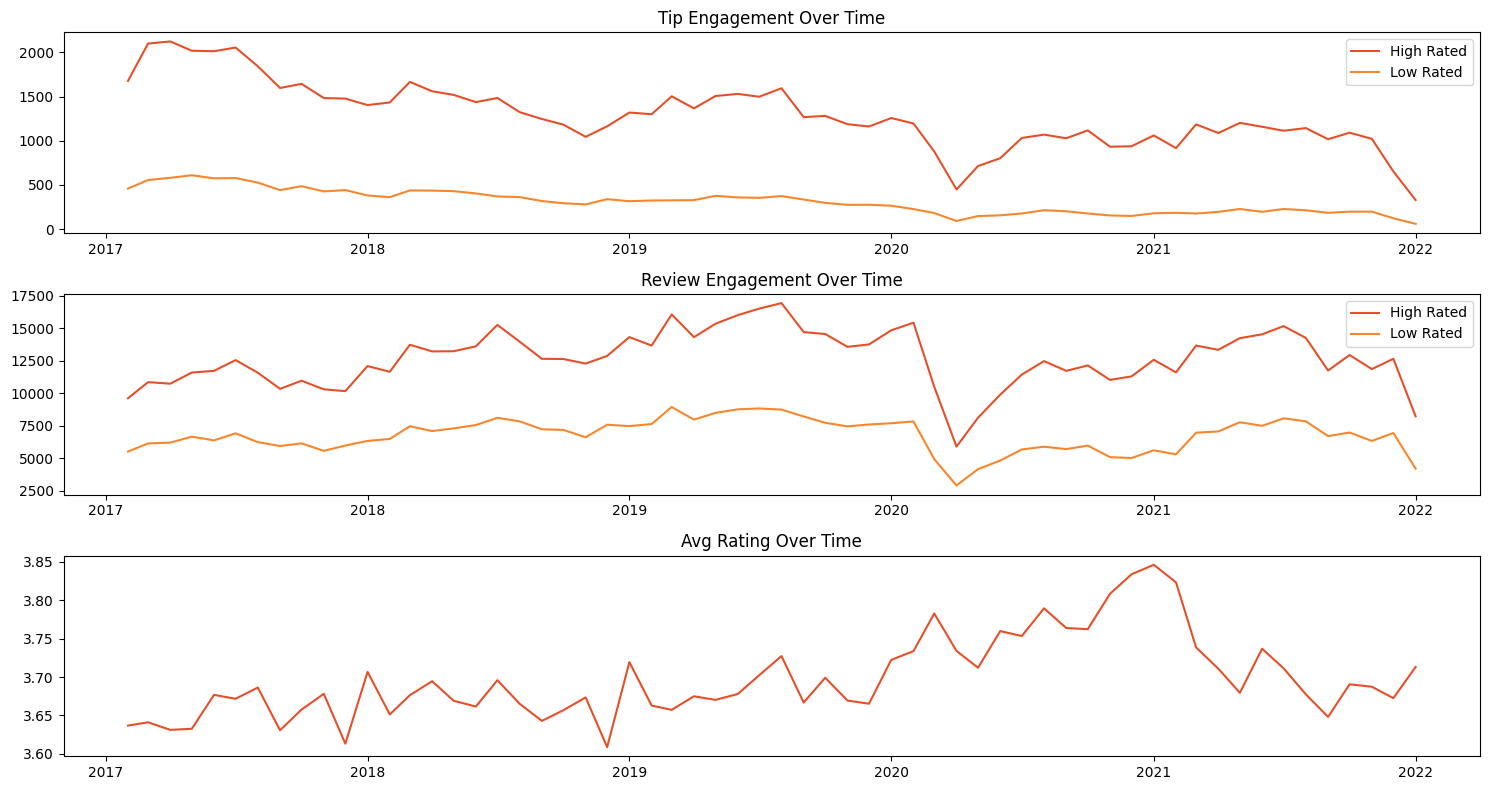

In [80]:
plt.figure(figsize=(15, 8))

# Subplot 1: Tip Engagement Over Time
plt.subplot(3, 1, 1)
plt.title('Tip Engagement Over Time')
plt.plot(high_rated_engagement['month_year'], high_rated_engagement['tip_count'], label='High Rated', color='#E54F29')
plt.plot(low_rated_engagement['month_year'], low_rated_engagement['tip_count'], label='Low Rated', color='#F8862C')
plt.legend()

# Subplot 2: Review Engagement Over Time
plt.subplot(3, 1, 2)
plt.title('Review Engagement Over Time')
plt.plot(high_rated_engagement['month_year'], high_rated_engagement['review_count'], label='High Rated', color='#E54F29')
plt.plot(low_rated_engagement['month_year'], low_rated_engagement['review_count'], label='Low Rated', color='#F8862C')
plt.legend()

# Subplot 3: Avg Rating Over Time
plt.subplot(3, 1, 3)
plt.title('Avg Rating Over Time')
plt.plot(time_rating['month_year'], time_rating['avg_rating'], color='#E54F29')

plt.tight_layout()
plt.show()


In [82]:
# Set index to 'month_year' for decomposition
tip_high_rated = high_rated_engagement[['month_year', 'tip_count']].set_index('month_year')
review_high_rated = high_rated_engagement[['month_year', 'review_count']].set_index('month_year')
rating_df = time_rating[['month_year', 'avg_rating']].set_index('month_year')

# Import and apply seasonal decomposition
from statsmodels.tsa.seasonal import seasonal_decompose

multiplicative_decomposition = seasonal_decompose(
    tip_high_rated,
    model='multiplicative',
    period=12
)




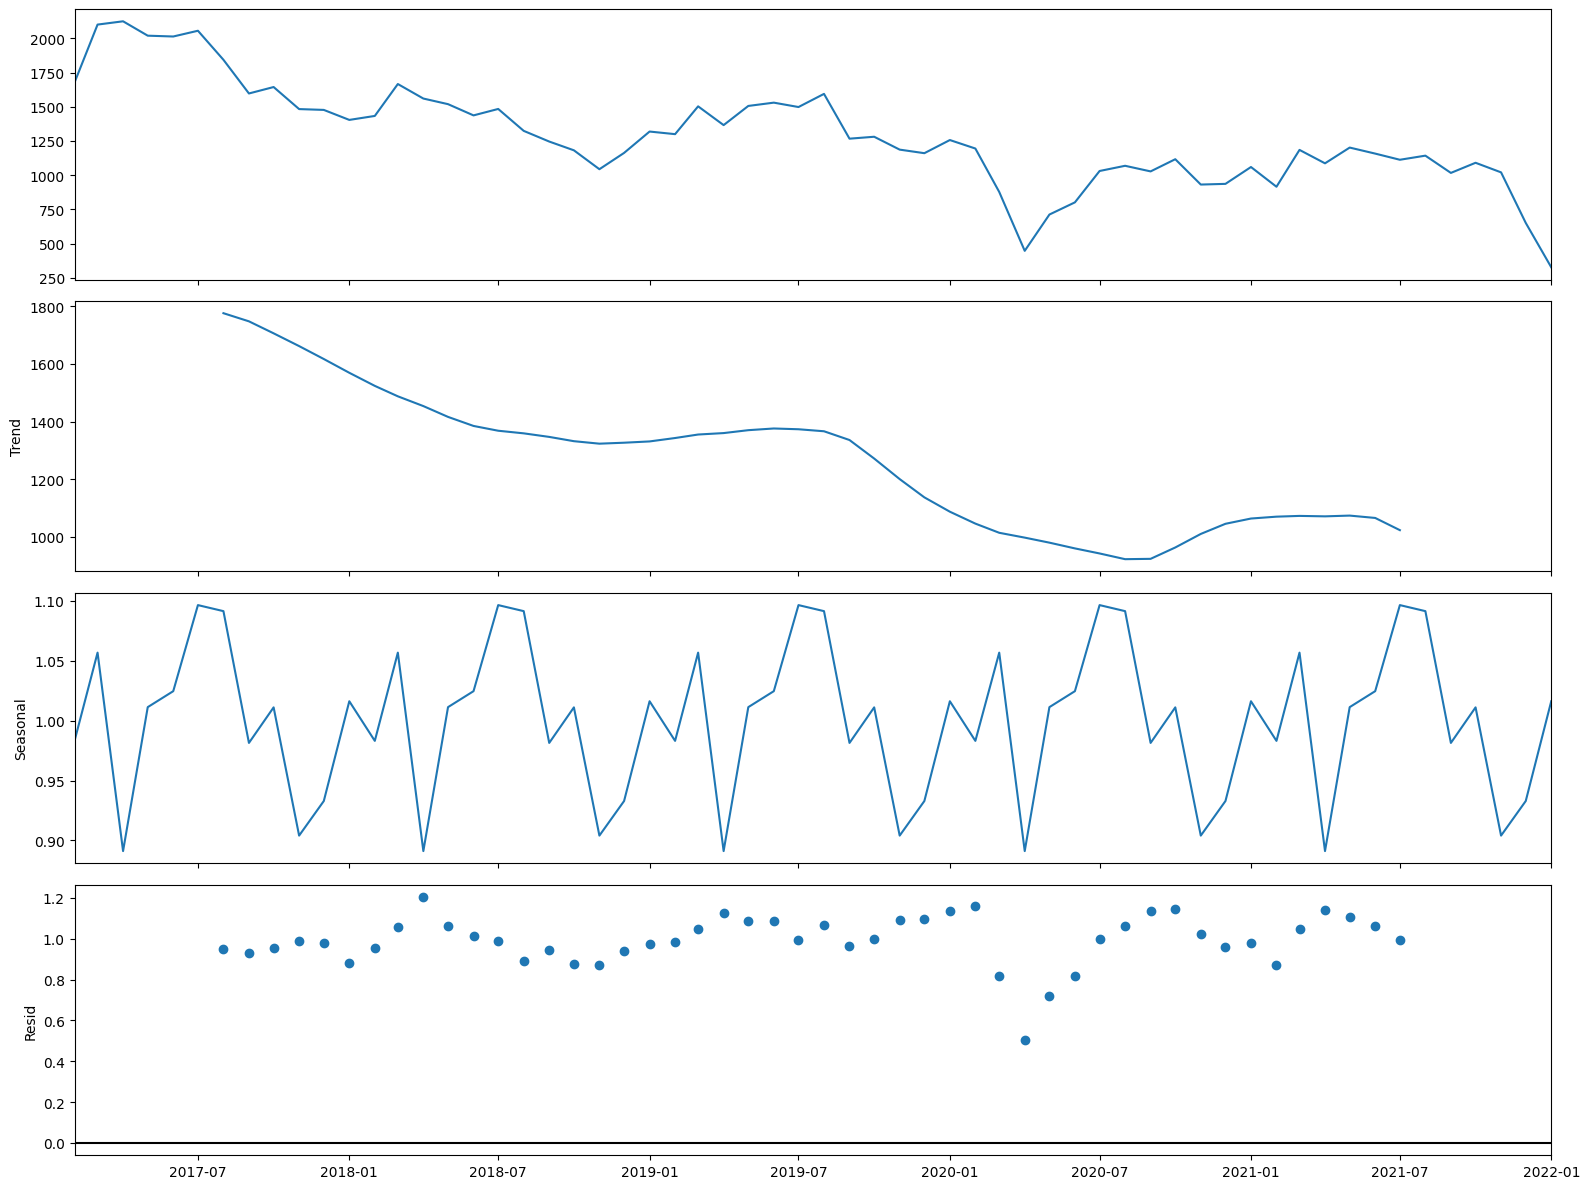

In [83]:


# Plot the decomposition
plt.rcParams.update({'figure.figsize': (16, 12)})
multiplicative_decomposition.plot()
plt.show()


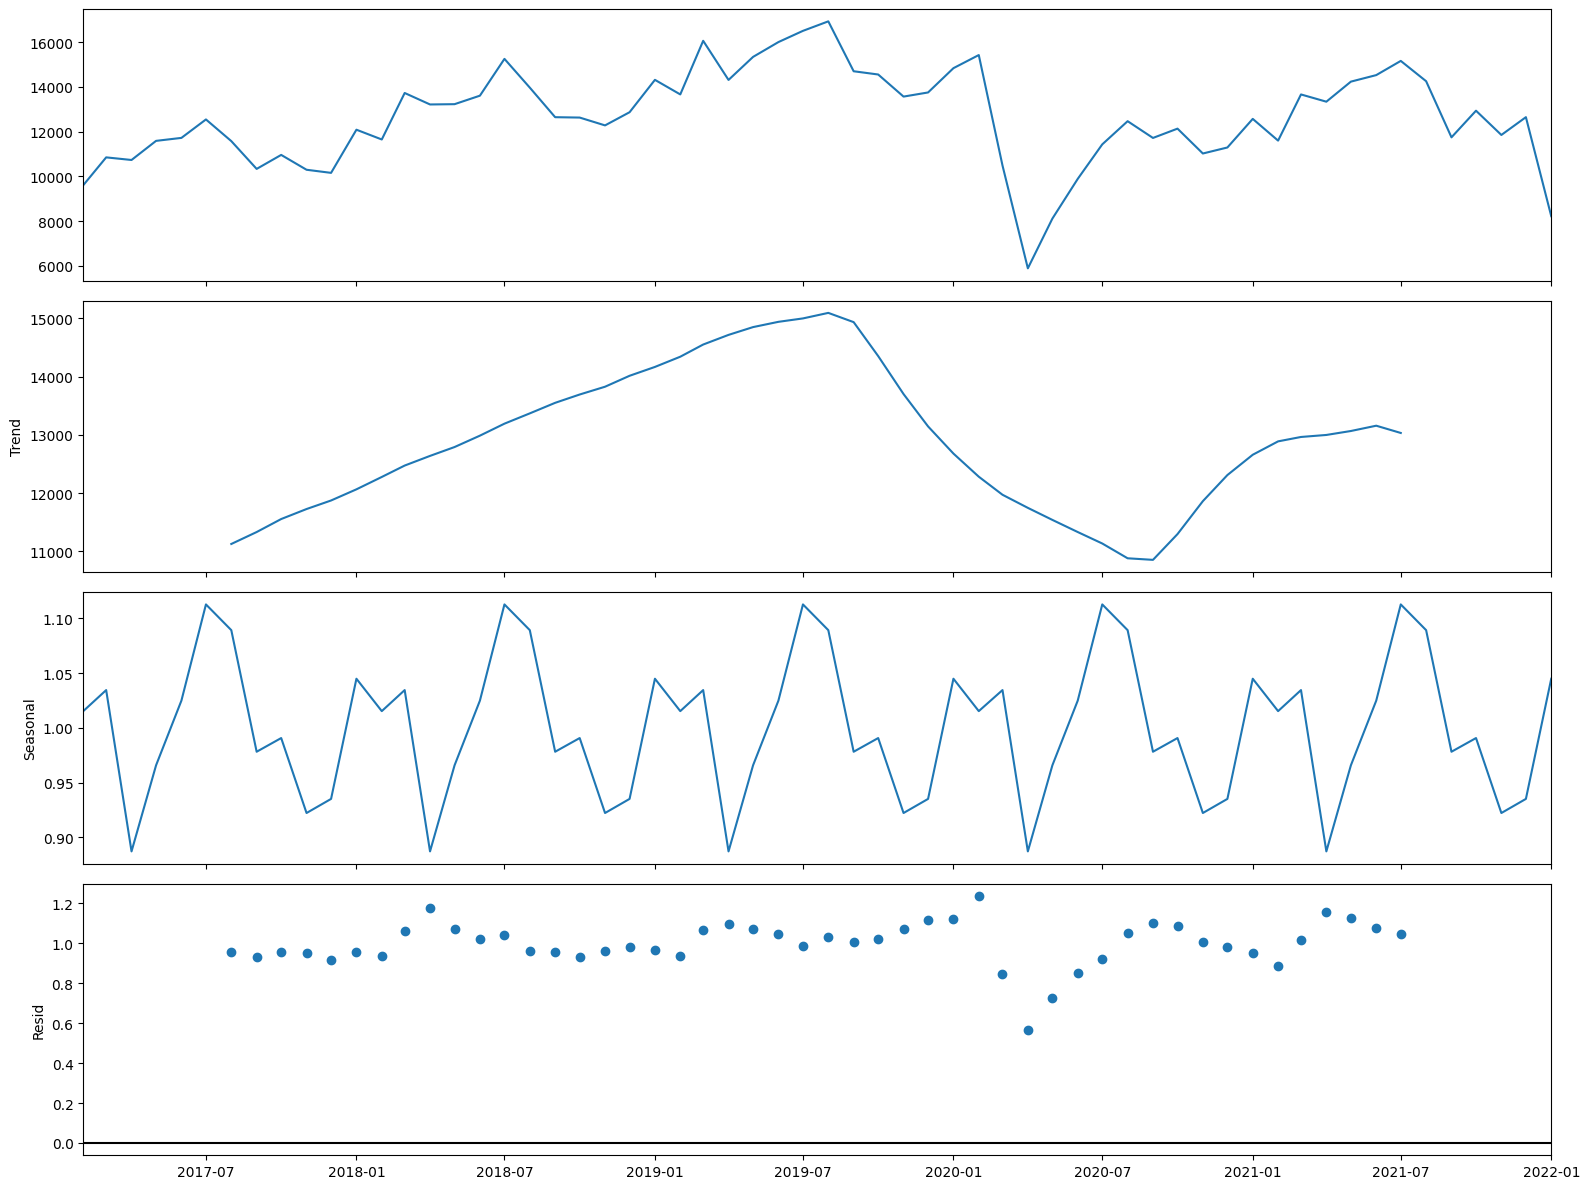

In [84]:
multiplicative_decomposition = seasonal_decompose(
    review_high_rated,
    model='multiplicative',
    period=12
)
plt.rcParams.update({'figure.figsize': (16, 12)})
multiplicative_decomposition.plot()
plt.show()


In [87]:
#sentiment analysis
#how does the sentiment correlate with the succes metrix of this restaurant.?
sentiment_df = pd.read_sql_query(f"""
    SELECT 
        b.business_id, 
        AVG(b.stars) AS avg_rating, 
        SUM(b.review_count) AS review_count,
        SUM(s.useful_count) AS useful_count,
        SUM(s.funny_count) AS funny_count,
        SUM(s.cool_count) AS cool_count
    FROM (
        SELECT 
            business_id,
            SUM(useful) AS useful_count,
            SUM(funny) AS funny_count,
            SUM(cool) AS cool_count
        FROM review
        GROUP BY business_id
    ) AS s
    JOIN business AS b ON b.business_id = s.business_id
    WHERE b.business_id IN {tuple(business_id['business_id'])}
    GROUP BY b.business_id
    ORDER BY review_count
""", conn)
sentiment_df = remove_outliers(sentiment_df,'review_count')
sentiment_df = remove_outliers(sentiment_df,'useful_count')
sentiment_df = remove_outliers(sentiment_df,'funny_count')
sentiment_df = remove_outliers(sentiment_df,'cool_count')


In [88]:
sentiment_df['success_score'] = calculate_success_metric(sentiment_df)

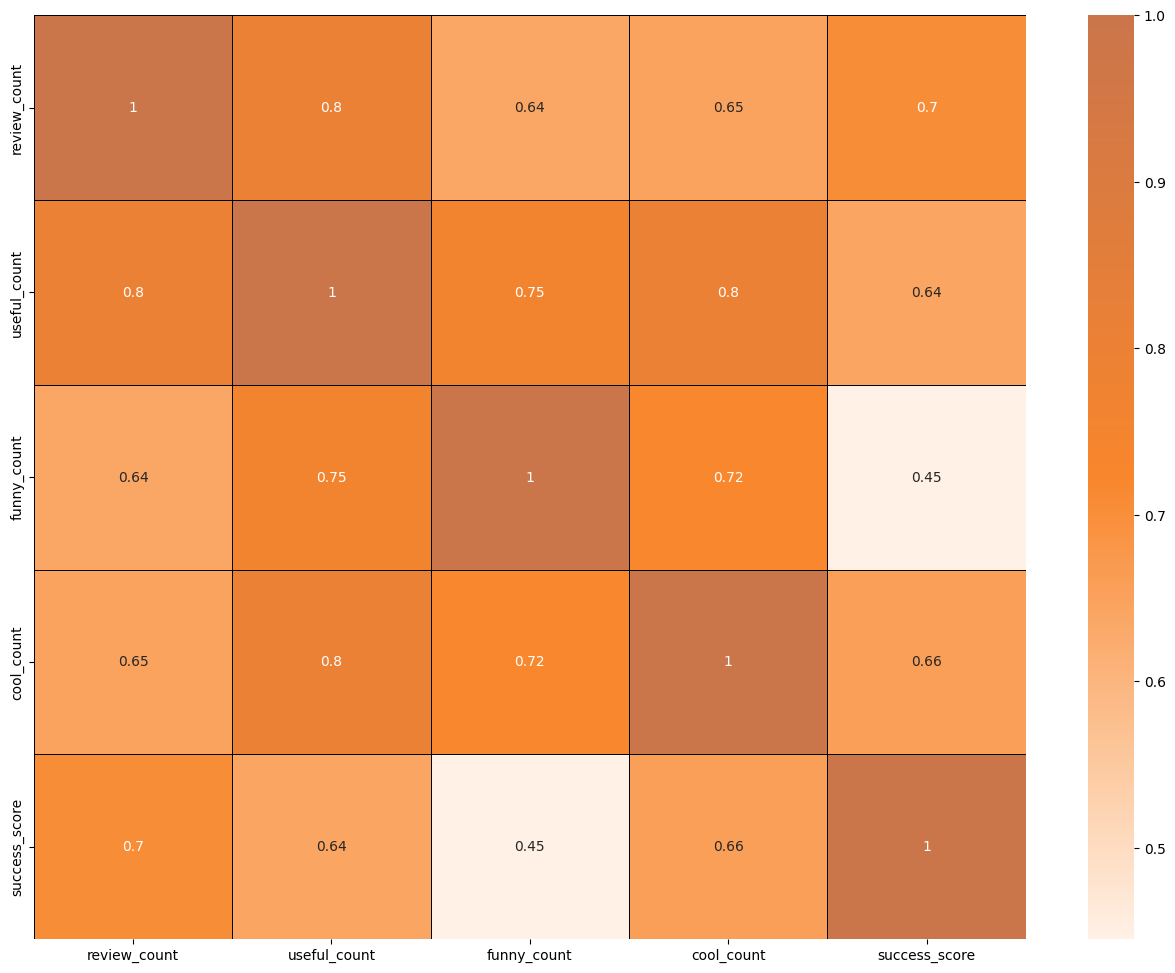

In [91]:
sns.heatmap(sentiment_df.iloc[:,2:].corr(), cmap = custom_cmap, annot = True, linewidths = 0.5, linecolor = 'black')
plt.show()

In [93]:
# Is there any difference in engagement of elite users and non-elite users?
elite_df = pd.read_sql_query("""
    SELECT 
        elite,
        COUNT(*) AS row_count,
        SUM(review_count) AS total_review_count
    FROM (
        SELECT 
            CASE 
                WHEN elite = '' THEN 'Not Elite'
                ELSE 'Elite'
            END AS elite,
            u.review_count
        FROM user u
    ) AS user_elite
    GROUP BY elite
""", conn)


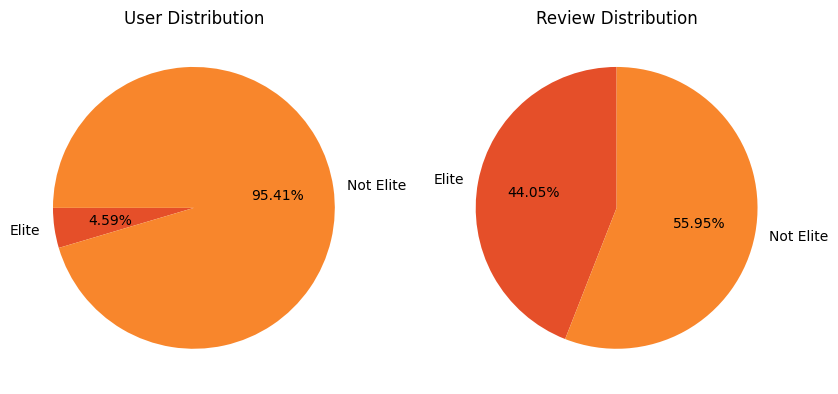

In [94]:
plt.figure(figsize=(10, 6))

# Pie chart for user distribution
plt.subplot(1, 2, 1)
plt.title('User Distribution')
plt.pie(elite_df['row_count'], 
        labels=elite_df['elite'], 
        autopct='%.2f%%', 
        startangle=180, 
        colors=['#E54F29', '#F8862C'])

# Pie chart for review count distribution
plt.subplot(1, 2, 2)
plt.title('Review Distribution')
plt.pie(elite_df['total_review_count'], 
        labels=elite_df['elite'], 
        autopct='%.2f%%', 
        startangle=90, 
        colors=['#E54F29', '#F8862C'])

plt.show()


In [96]:
#what are the busiest hours of the restaurant so that they dont have the problems.?
# Query review engagement by hour
review_engagement = pd.read_sql_query("""
    SELECT 
        CAST(STRFTIME('%H', date) AS INTEGER) AS hour,
        COUNT(*) AS review_count
    FROM review
    GROUP BY hour
""", conn)

# Query tip engagement by hour
tip_engagement = pd.read_sql_query("""
    SELECT 
        CAST(STRFTIME('%H', date) AS INTEGER) AS hour,
        COUNT(*) AS tip_count
    FROM tip
    GROUP BY hour
""", conn)

# Query check-in data
checkin = pd.read_sql_query("SELECT date FROM checkin", conn)

# Process check-in timestamps
checkin_engagement = []
for i in checkin['date']:
    checkin_engagement.extend([
        datetime.strptime(j.strip(), "%Y-%m-%d %H:%M:%S").strftime("%H") 
        for j in i.split(',') if j.strip()
    ])

# Create DataFrame and count by hour
checkin_engagement = pd.DataFrame(checkin_engagement).astype('int')
checkin_engagement = checkin_engagement.groupby(0)[0].count()


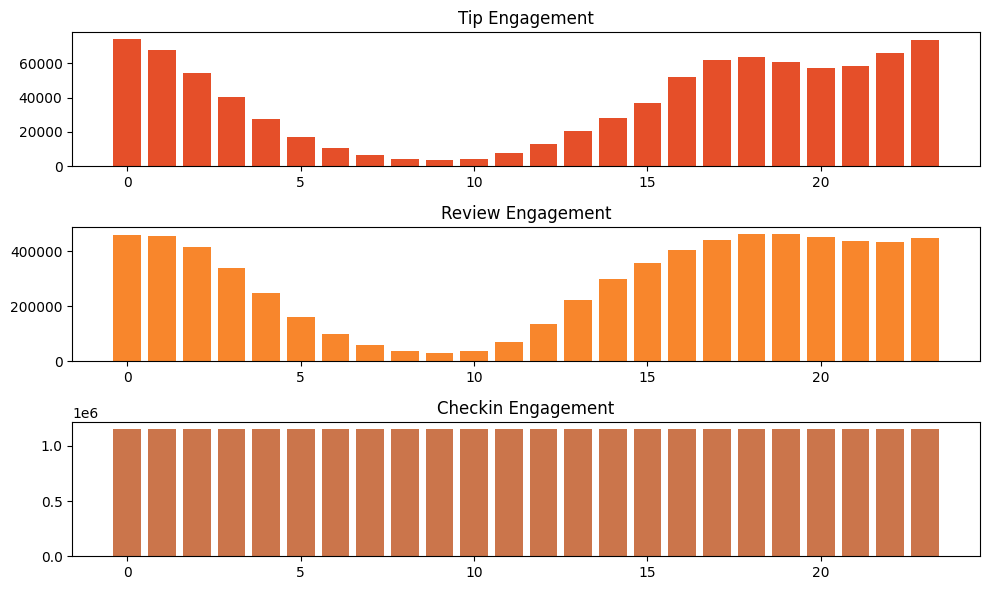

In [98]:
plt.figure(figsize=(10, 6))

# Subplot 1: Tip Engagement by Hour
plt.subplot(3, 1, 1)
plt.title('Tip Engagement')
plt.bar(tip_engagement['hour'], tip_engagement['tip_count'], color='#E54F29')

# Subplot 2: Review Engagement by Hour
plt.subplot(3, 1, 2)
plt.title('Review Engagement')
plt.bar(review_engagement['hour'], review_engagement['review_count'], color='#F8862C')

# Subplot 3: Check-in Engagement by Hour
plt.subplot(3, 1, 3)
plt.title('Checkin Engagement')
plt.bar(checkin_engagement.index, checkin_engagement[0], color='#CB754B')

# Adjust layout and display all plots
plt.tight_layout()
plt.show()
